# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import cv2
import imageio
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)




In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Upgrad/RNN/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Upgrad/RNN/Project_data/Project_data/val.csv').readlines())
batch_size = 50
#experiment with the batch size


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = cv2.resize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data

                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches

        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = cv2.resize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data

                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:

curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Upgrad/RNN/Project_data/Project_data/train'
val_path = '/content/gdrive/MyDrive/Upgrad/RNN/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)
# choose the number of epochs
#generator(train_path, train_doc, batch_size)




# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [ ]:
model_al1 = Sequential()

model_al1.add(Conv3D(8, #number of filters
                 kernel_size=(3,3,3),
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model_al1.add(BatchNormalization())
model_al1.add(Activation('relu'))

model_al1.add(MaxPooling3D(pool_size=(2,2,2)))

model_al1.add(Conv3D(16, #Number of filters,
                 kernel_size=(3,3,3),
                 padding='same'))
model_al1.add(BatchNormalization())
model_al1.add(Activation('relu'))

model_al1.add(MaxPooling3D(pool_size=(2,2,2)))

model_al1.add(Conv3D(32, #Number of filters
                 kernel_size=(3,3,3),
                 padding='same'))
model_al1.add(BatchNormalization())
model_al1.add(Activation('relu'))

model_al1.add(MaxPooling3D(pool_size=(2,2,2)))

model_al1.add(Conv3D(64, #Number pf filters
                 kernel_size=(3,3,3),
                 padding='same'))
model_al1.add(BatchNormalization())
model_al1.add(Activation('relu'))

model_al1.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_al1.add(Flatten())

model_al1.add(Dense(1000, activation='relu'))
model_al1.add(Dropout(0.5))

model_al1.add(Dense(500, activation='relu'))
model_al1.add(Dropout(0.5))

#softmax layer
model_al1.add(Dense(5, activation='softmax'))



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_al1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_al1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_4 (Bat  (None, 30, 120, 120, 8)   32        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 15, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_5 (Bat  (None, 15, 60, 60, 16)   

Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
print("training generator done")
val_generator = generator(val_path, val_doc, batch_size)
print("validation generator done")

training generator done
validation generator done


In [ ]:


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]




In [ ]:


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(steps_per_epoch)
print(validation_steps)



14
2


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model_al1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-23-2dbeb5e89a4d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_al1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-6-502af651a6fd>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  /content/gdrive/MyDrive/Upgrad/RNN/Project_data/Project_data/train ; batch size = 50
Epoch 1/30
11/14 [======================>.......] - ETA: 2:55 - loss: 4.0411 - categorical_accuracy: 0.2364Batch:  14 Index: 50


<ipython-input-6-502af651a6fd>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


14/14 [==============================] - ETA: 0s - loss: 3.6238 - categorical_accuracy: 0.2519 Source path =  /content/gdrive/MyDrive/Upgrad/RNN/Project_data/Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2023-12-0412_48_39.221333/model-00001-3.62377-0.25189-1.54456-0.23000.h5
14/14 [==============================] - 879s 62s/step - loss: 3.6238 - categorical_accuracy: 0.2519 - val_loss: 1.5446 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.5499 - categorical_accuracy: 0.3516 
Epoch 2: saving model to model_init_2023-12-0412_48_39.221333/model-00002-1.54987-0.35165-1.43839-0.34000.h5
14/14 [==============================] - 280s 20s/step - loss: 1.5499 - categorical_accuracy: 0.3516 - val_loss: 1.4384 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 1.4213 - categorical_accuracy: 0.4066 
Epoch 3: saving model to model_init_20

## Model 2: 2D Conv + RNN (Transfer Learning using MobileNet)

In [ ]:
batch_size = 10
num_epochs = 25
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures
channel = 3 #RGB

In [ ]:
from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LSTM

In [ ]:
model_2 = Sequential()
model_2.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,channel)))

model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_2.add(TimeDistributed(Flatten()))

model_2.add(GRU(128))
model_2.add(Dropout(0.25))

model_2.add(Dense(128,activation='relu'))
model_2.add(Dropout(0.25))

model_2.add(Dense(5, activation='softmax'))

In [ ]:
train_generator2 = generator(train_path, train_doc, batch_size)
val_generator2 = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 30, 3, 3, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 30, 1024)          0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 128)              

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model_2.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator2,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-31-e74d0b95d50a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_2.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-6-502af651a6fd>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  /content/gdrive/MyDrive/Upgrad/RNN/Project_data/Project_data/train ; batch size = 10
Epoch 1/25
64/67 [===========================>..] - ETA: 1:12 - loss: 1.1394 - categorical_accuracy: 0.5484Batch:  67 Index: 10


<ipython-input-6-502af651a6fd>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.1261 - categorical_accuracy: 0.5551 Source path =  /content/gdrive/MyDrive/Upgrad/RNN/Project_data/Project_data/val ; batch size = 10

Epoch 1: saving model to model_init_2023-12-0412_48_39.221333/model-00001-1.12605-0.55505-0.73221-0.66000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 1714s 25s/step - loss: 1.1261 - categorical_accuracy: 0.5551 - val_loss: 0.7322 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2530 - categorical_accuracy: 0.4826
Epoch 2: saving model to model_init_2023-12-0412_48_39.221333/model-00002-1.25299-0.48259-1.02965-0.58000.h5
67/67 [==============================] - 558s 8s/step - loss: 1.2530 - categorical_accuracy: 0.4826 - val_loss: 1.0296 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.0419 - categorical_accuracy: 0.6020
Epoch 3: saving model to model_init_2023-12-0412_48_39.221333/model-00003-1.04188-0.60199-1.17982-0.57000.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
67/67 [==============================] - 524s 8s/step - loss: 1.0419 - categorical_accuracy: 0.6020 - val_loss: 1.1798 - val_categorical_accuracy: 0.5700 - l

In [ ]:
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

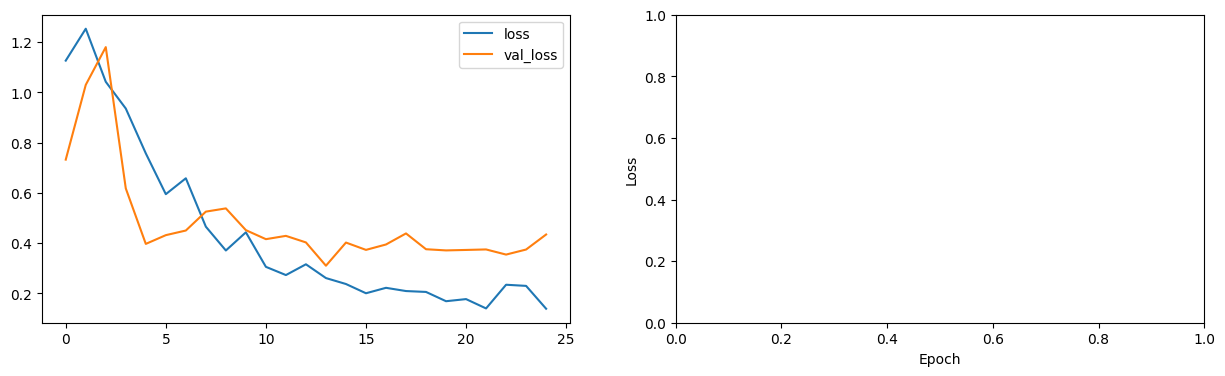

In [ ]:
plot(history)